<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from scipy import sparse
from html.parser import HTMLParser
from tqdm import tqdm

import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle



# from scipy.sparse import csr_matrix, hstack

The following code will help to throw away all HTML tags from an article content.

In [1]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [2]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [3]:
def extract_features_and_write(path_to_data, inp_filename, is_train=True):
    prefix = 'train' if is_train else 'test'

    content_test = []
    # vector = TfidfVectorizer(ngram_range=(1, 2), max_features=100_000)
    with open(os.path.join(path_to_data, inp_filename), encoding='utf-8') as inp_json_file:
        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)

            features['title'] += [json_data['title']]
            features['author'] += [re.split(r'@', json_data['author']['url'])[1]]
            features['reading_t'] += re.findall(r'\d+', json_data['meta_tags']['twitter:data1'])

            tag_search = re.findall(r"/medium.com/tag/(.+?)(?:\?source|\"|\/)", json_data['content'])
            features['tags'] += [' '.join(tag_search)]

            published_split = re.split(r'T', json_data['published']['$date'])
            features['date'] += [published_split[0]]
            features['time'] += [re.split(r"\.", published_split[1])[0]]

            content_no_html = strip_tags(json_data['content'].replace('\n', ' ').replace('\r', ' '))
            content_space_char = re.sub(r"([a-z])([A-Z])", r"\1 \2", content_no_html)
            content_space_point = re.sub(r"(\.)([A-Z])", r"\1 \2", content_space_char)
            content_space_digits = re.sub(r"(\d+)(\w+)", r"\1 \2", content_space_point)
            content_space_quest = re.sub(r"(\?)(\w+)", r"\1 \2", content_space_digits)
            features['content'] += [content_space_quest]

        for feature in features.keys():
            with open(os.path.join(path_to_data, prefix + '_' + feature + '_pickle'), 'wb') as pick:
                pickle.dump(features[feature], pick)

In [6]:
PATH_TO_DATA = 'C:/Users/Tom/PycharmProjects/Start/GibHub/Jupyter_Notebook/data_6/'
features = {'content': [], 'title': [], 'tags': [], 'author': [], 'date': [], 'time': [], 'reading_t': []}

In [ ]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [ ]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [48]:
# Векторизируем
def vector(data):
    vector = TfidfVectorizer(ngram_range=(1, 2), max_features=100_000)
    return vector.fit_transform(tqdm(data))


# vec_features = {'train': features, 'test': features}
# for typez in vec_features.keys():
#     for feature in features.keys():
#         with open(os.path.join(PATH_TO_DATA, typez + '_' + feature + '_pickle'), 'rb') as pick:
#             data = pickle.load(pick)
#             vec_features[typez][feature] = vector(data)
            
with open(os.path.join(PATH_TO_DATA, 'train_content_pickle'), 'rb') as pick:
    data = pickle.load(pick)
    X_train_cont = vector(data)
    
with open(os.path.join(PATH_TO_DATA, 'test_content_pickle'), 'rb') as pick:
    data = pickle.load(pick)
    X_test_cont = vector(data)

100%|███████████████████████████████████████████████████████████████████████████| 34645/34645 [01:52<00:00, 308.27it/s]


**Join all sparse matrices.**

In [ ]:
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse, 
                         X_train_time_features_sparse]).tocsr()

In [ ]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse, 
                        X_test_time_features_sparse]).tocsr()

**Read train target and split data for validation.**

In [49]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [50]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train_cont[:train_part_size, :]  # X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid = X_train_cont[train_part_size:, :]  # X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [51]:
print(len(y_valid))
print(X_valid.shape)

18694
(18694, 100000)


**Train a simple Ridge model and check MAE on the validation set.**

18694
18694
18694


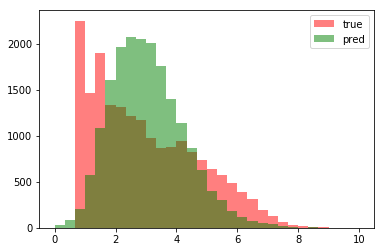

In [52]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=17)
ridge.fit(X_train_part, y_train_part)
ridge_pred = ridge.predict(X_valid)

print(len(y_valid))
print(X_valid.shape[0])
print(len(ridge_pred))

plt.hist(y_valid, bins=30, alpha=0.5, color='red', label='true', range=(0, 10))
plt.hist(ridge_pred, bins=30, alpha=0.5, color='green', label='pred', range=(0, 10))
plt.legend()

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [53]:
# You code here
valid_mae = mean_absolute_error(y_valid, ridge_pred)
print(valid_mae, np.expm1(valid_mae))

ridge.fit(X_train_cont, y_train)
ridge_test_pred = ridge.predict(X_test_cont)

1.1534047529371754 2.168964102495093


In [46]:
def write_submission_file(prediction, filename, path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [54]:
print(ridge_test_pred.shape)
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA, 'assignment6_medium_submission.csv'))

(34645,)


**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [56]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [55]:
ridge_test_pred_modif = ridge_test_pred # You code here

In [57]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_with_hack.csv'))

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>